In [35]:
from confirm.outlaw.nb_util import setup_nb

setup_nb()
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from confirm.mini_imprint import batch, grid, newlib, adagrid, driver

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
@jax.jit
def _sim(samples, theta, null_truth):
    return jnp.where(
        null_truth[:, None, 0],
        # negate so that we can do a less than comparison
        -(theta[:, None, 0] + samples[None, :]),
        jnp.inf,
    )


class ZTest1D:
    def __init__(self, seed, max_K, sim_batch_size=2048):
        self.family = "normal"
        self.sim_batch_size = sim_batch_size
        self.dtype = jnp.float32

        # sample normals and then compute the CDF to transform into the
        # interval [0, 1]
        key = jax.random.PRNGKey(seed)
        self.samples = jax.random.normal(key, shape=(max_K,), dtype=self.dtype)
        self._sim_batch = batch.batch(
            _sim, self.sim_batch_size, in_axes=(0, None, None), out_axes=(1,)
        )

    def sim_batch(self, begin_sim, end_sim, theta, null_truth, detailed=False):
        return self._sim_batch(self.samples[begin_sim:end_sim], theta, null_truth)

In [37]:
K = 8196 * 32
model = ZTest1D(seed=0, max_K=K)

N = 500
theta, radii = grid.cartesian_gridpts([-1], [1], [N])
g = newlib.init_grid(theta, radii, K).add_null_hypo(0).prune()

# TODO: is there any problem from using the same seed with the bootstrap
# indices and the simulations?
dd = driver.Driver(model)

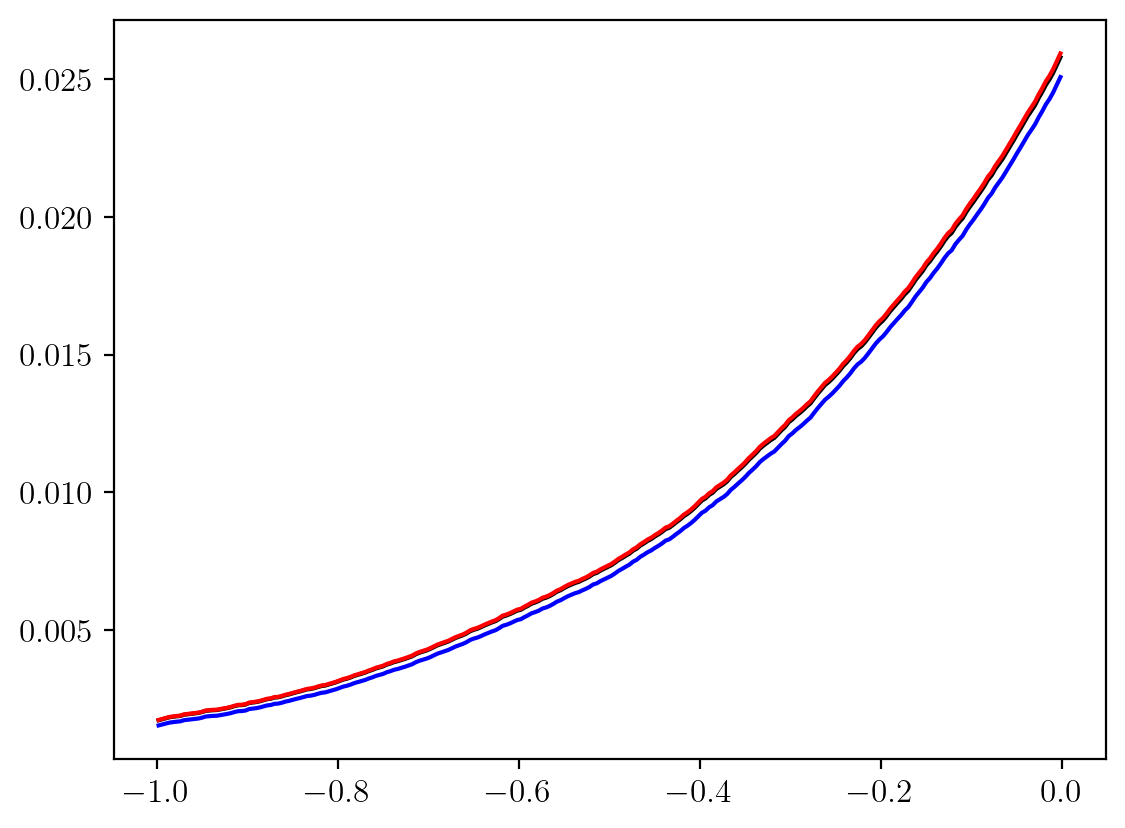

In [38]:
# lam = -1.96 because we negated the statistics so we can do a less than
# comparison.
rej_data = dd.rej(g, -1.96).df

In [ ]:
plt.plot(rej_data["theta0"], rej_data["TI_est"], "b-")
plt.plot(rej_data["theta0"], rej_data["TI_cp_bound"], "k-")
plt.plot(rej_data["theta0"], rej_data["TI_bound"], "r-")
plt.show()

In [ ]:
init_K = 2048
n_K_double = 4
nB = 5
ada = adagrid.AdagridDriver(model, init_K, n_K_double, nB, bootstrap_seed=0)

In [ ]:
%%time
g_tune = ada.bootstrap_tune(g)

CPU times: user 839 ms, sys: 10 ms, total: 849 ms
Wall time: 845 ms


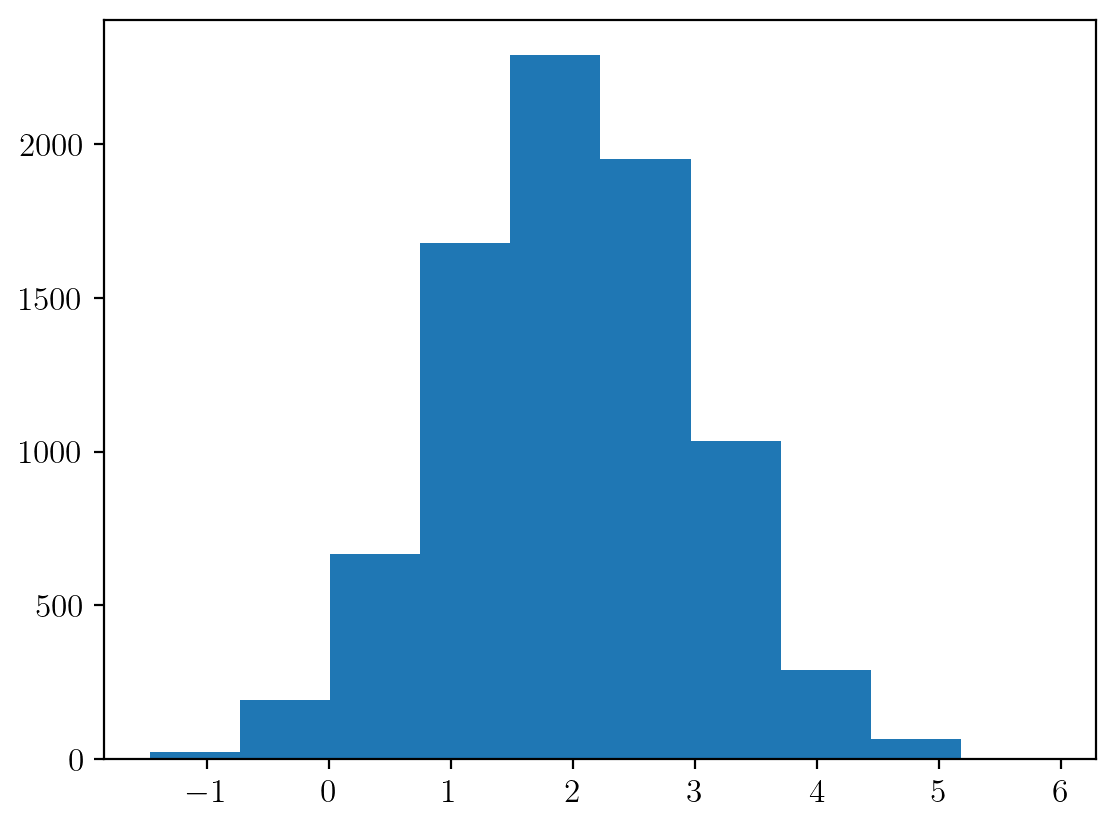

In [ ]:
import matplotlib.pyplot as plt

stats = dd.stats(g).iloc[0]
plt.hist(stats[0])
plt.show()